## AERIAL IMAGE FLOOD MAPPING - GAUSSIAN MIXTURE MODELS - 02

INTRODUCTION

This notebook generates a Gaussian Mixture Model for a set of aerial images of floods. The Gaussian Mixture Model groups each pixel into a set of clusters. It is expected that one, or some combination of these clusters will represent the flood area in these images.

The preprocessing stage of this notebook involves loading the images, converting them into the HSV color space, and for each image maximising the Value channel for each pixel so as to eliminate the effect of light and shadow on each pixel.  

Previous notebooks have used some statistical process to determine the optimal number of clusters for the unsupervised clustering algorithm. Technically, Gaussian Mixture Models are generative probability distribution models. The the Bayesian Informational Criterion and Akaike Informational Criterion measure the complexity and performance of a given model, they do not measure the reduction in covariance of models with increasing numbers of clusters. Therefore these statistical measurements were not used to inform the selection of n_components. Instead, a large value for n_components is used with the aim of dividing the flood area over two or more clusters. Further processing is used to determine which clusters represent a flood area and then combine them. It should be remembered that this notebook only tests a small number of images.

The input NRG images are in JP2 format and contain the near-infrared, red, and green channels. The input for the Gaussian Mixture Model uses the near-infrared channel as well as the hue and saturation channels obtained from converting the original image into the HSV colour space.  

To automate the selection of the clusters containing the flood area, each cluster is masked back onto the original JP2 image containing the NRG channels to generate a series of masks. Each of these masks is then examined to count the proportion of how many pixels it has with the green channel containing the highest value. If the proportion of green-dominant pixels is above some threshold value, it is assumed such masks will represent a flood area to be combined into a complete flood extent area. The threshold value is chosen by creating a histogram plot for each of the masks plotting the frequency of pixel intensities. The histograms for known flood clusters are compared to histograms representing known non-flood clusters. A threshold value is then chosen by comparing the output.


In [1]:
# standard libraries
import os
import sys
import subprocess

# computer vision libraries
import cv2
import matplotlib.pylab as plt
import skimage
from skimage import io
import sklearn.mixture
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

# data libraries
import numpy as np
import pandas as pd
from PIL import Image

# aws libraries
import boto3

print("libraries imported")

libraries imported


In [2]:
def max_rgb_filter(image):
    """This method examines each pixel in an RGB image, determines which channel has the highest value, and maximises that channel while
    setting the other channels to 0.

    Keyword argument:
    image - an image in RGB color space prepared with the skimage library
    """
    (R, G, B, _) = cv2.split(image)
    M = np.maximum(np.maximum(R, G), B)
    R[R < M] = 0
    G[G < M] = 0
    B[B < M] = 0
    return cv2.merge([R, G, B, _])


def max_hsv_filter(image):
    """This method examines each pixel in a HSV image, determines which channel has the highest value, and maximises that channel while
    setting the other channels to 0.

    Keyword argument:
    image - an image in HSV color space prepared with the skimage library
    """
    (H, S, V) = cv2.split(image)
    M = np.maximum(np.maximum(H, S), V)
    H[H < M] = 0
    S[S < M] = 0
    V[V < M] = 0
    return cv2.merge([H, S, V])


def max_v_filter(image): # max value reduces shadows
    """This method maximises the value channel for each pixel in an image in HSV color space. 
    The logic is that maximising the value channel will eliminate the effect of light and shadow on each pixel.

    Keyword argument:
    image -- an image in HSV color space prepared with the skimage library
    """
    (H, S, V) = cv2.split(image)
    V[True] = 255
    return cv2.merge([H, S, V])


def gmm_hsv(img_list):
    """This method generates a Gaussian Mixture Model for a HSV image and outputs a list of clusters for each image. Although a GMM
    is a generative probability distribution which does not give hard assignments, for the purposes of this task it can be treated as
    if it were.

    Keyword arguments:
    img_list -- a list of images in HSV color space
    """
    cluster_img_list = []

    for img in img_list:
        (H, S, V) = cv2.split(img)
        pixel_channels = cv2.merge([H, S, V])
        input_vector = pixel_channels.reshape((-1, 3))

        gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
        clusters = gmm.fit_predict(input_vector)
        cluster_img = clusters.reshape(pixel_channels.shape[0], pixel_channels.shape[1])

        gmm_clusters = []
        for j in range(gmm.n_components):
            gmm_clusters.append((cluster_img == j))
        cluster_img_list.append(gmm_clusters)

    return cluster_img_list


def _gmm_hsv(img_list, n):
    """This method is identical to the one above except it also accepts parameter <n> to be passed as the value for n_components in the Gaussian
    Mixture Model.

    Keyword arguments:
    img_list -- a list of images in HSV color space
    n -- an integer value for the number of components in the GMM
    """
    cluster_img_list = []

    for img in img_list:
        (H, S, V) = cv2.split(img)
        pixel_channels = cv2.merge([H, S, V])
        input_vector = pixel_channels.reshape((-1, 3))

        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
        clusters = gmm.fit_predict(input_vector)
        cluster_img = clusters.reshape(pixel_channels.shape[0], pixel_channels.shape[1])

        gmm_clusters = []
        for j in range(gmm.n_components):
            gmm_clusters.append((cluster_img == j))
        cluster_img_list.append(gmm_clusters)

    return cluster_img_list


def mask_clusters_on_bgr(cluster_img_list, img_list):
    """This method takes a list of image clusters generated from the GMM, it then takes each cluster and maps it
    back onto the converted BGR image to create a mask for each cluster. It outputs a list of the same format as 
    the input list; an array of arrays where each element in the array represents a cluster of masks for a single
    image.

    Keyword argument:
    hsv_cluster_list -- array of arrays, each element in the array is a list of clusters for a single image
    this is generated from the gmm_hsv() function
    """
    masked_img_list = []

    for i in range(len(cluster_img_list)):
        cluster_img = np.array(cluster_img_list[i])
        img = img_list[i]
        cluster_list = []
        for j in range(len(cluster_img)):
            cluster = cluster_img[j]
            #masked_img = np.where(cluster[..., None], img, [255,255,255,255])
            masked_img = np.where(cluster[..., None], img, [255,255,255])
            cluster_list.append(masked_img)
        masked_img_list.append(cluster_list)
    
    return masked_img_list


def find_flood_cluster(masked_img_list):
    """This method accepts as input an array of masked image clusters. For each mask cluster it determines which one has the highest number of green-dominant
    pixels. It is assumed that this mask represents the flood cluster. This flood cluster is appended to a list and returned as output. 

    Keyword arguments:
    masked_img_list -- an array of arrays, each first-order array corresponds to a single image, each second-order array is a list
    of masks generated from each cluster of the GMM function
    """
    output = []

    for i in range(len(masked_img_list)):
        masked_img = masked_img_list[i]
        max_green_cluster = find_max_green_cluster(masked_img)
        output.append(masked_img[max_green_cluster[0]])
    
    return output


def find_max_green_cluster(masked_img):
    """This method calls the find_max_channel on each mask for each image to find which mask cluster has the highest number of pixels 
    with the green channel containing the highest value; this is assumed to be a flood cluster pixel.
    The cluster with the highest green pixel value is stored in the max_green_count vector with the first element being the index of
    the cluster and the second element being the green pixel count.

    Keyword argument:
    masked_img -- an array of masks for a single image
    """
    max_green_count = [0,0]

    for i in range(len(masked_img)):
        mask = masked_img[i]
        channel_count = count_max_channel(mask)
        green_count = channel_count[2]/channel_count[0]
        if green_count > max_green_count[1]:
            max_green_count = [i, channel_count[2]/channel_count[0]]
    
    print(f"max green count: {max_green_count}")
    return max_green_count


def count_max_channel(mask):
    """This method accepts a bgr mask as input and counts for each pixel whether the red, green, or blue
    channel contains the maximum pixel value. This method will be used to select the cluster with the highest
    total count for maximum green pixels (it is assumed this will be the flood cluster)

    Keyword argument:
    img -- an rgb mask cluster generated from the mask__clusters_on_rgb() method
    """
    (B, G, R) = cv2.split(mask)
    pixels = cv2.merge([B, G, R])
    vector = pixels.reshape((-1, 3))
    blue_count = 0
    green_count = 0
    red_count = 0
    tot = 0
    for v in vector:
        if v[0] != 255 or v[1] != 255 or v[2] != 255:
            tot += 1
            m = np.maximum(np.maximum(v[0], v[1]), v[2])
            if m == v[0]:
                blue_count += 1
            elif m == v[1]:
                green_count += 1
            elif m == v[2]:
                red_count += 1

    return [tot, blue_count, green_count, red_count]


def find_flood_clusters(masked_img_list):
    """This method accepts as input an array of masked image clusters. For each set of mask cluster it determines which mask(s) has the a proportion of  
    green-dominant pixels above some threshold value. It is assumed that these masks represent the flood cluster. These flood clusters are appended 
    to a list and returned as output. 

    Keyword arguments:
    masked_img_list -- an array of arrays, each first-order array corresponds to a single image, each second-order array is a list
    of masks generated from each cluster of the GMM function


    Plot colour intensities in historgram plot, compare flood cluster to non-flood clusters
    """

    output = []
    threshold_value = 0.65

    for i in range(len(masked_img_list)):
        masked_img = masked_img_list[i]
        flood_cluster = []
        for j in range(len(masked_img)):
            if (is_flood_cluster(masked_img[j], threshold_value)):
                print("found flood cluster")
                flood_cluster.append(masked_img[j])
        if len(flood_cluster) > 1: # if more than one mask, stitch together
            for k in range(len(flood_cluster)-1):
                print("stitching masks together")
                combined_mask = np.bitwise_or(flood_cluster[k], flood_cluster[k+1])
            output.append(combined_mask)
        else:
            output.append(flood_cluster)
    
    return output


def is_flood_cluster(mask, thresh):
    """This method uses an threshold value passed as the argument <thresh> to test if a given cluster is a flood cluster or not. It calls on the method 
    count_max_channel to obtain a count of the dominant channel for each pixel. If the proportion of green-dominant pixels is above the threshold value, then
    the function returns True, indicating that it is a flood cluster. Otherwise it returns False, indicating that it is not a flood cluster.
    
    Keyword arguments:
    mask -- an rgb mask cluster
    thresh -- an float value between 0.0 and 1.0 used as an arbitrary threshold 
    """
    channel_count = count_max_channel(mask)
    green_count = channel_count[2]/channel_count[0]
    if green_count > thresh:
        return True
    else:
        return False



def pltImages(images):
    """This method plots the images in a grid with 4 columns.and
    
    Keyword argument:
    images - an array of images
    """
    import math
    
    if (len(images)) >= 4:
        columns = 4
    else:
        columns = len(images)
    rows = math.floor(len(images) / 4)
    if (len(images) % 4) > 0:
        rows += 1
    total_plots = rows * columns
    
    _, ax = plt.subplots(rows, columns, sharey=True, figsize=(20,20))
    blank = np.full(images[0].shape[:2], 0, dtype='uint8')

    if (len(images) == 1):
        ax.imshow(images[0], cmap='viridis')
        ax.grid(b=False)

    if (rows == 1):
        for i in range(total_plots):
            if (i < len(images)):
                ax[i % columns].imshow(images[i], cmap='viridis') # KElbowVisualizer overwrites the cmap and grid settings for skimage.imshow()
                ax[i % columns].grid(b=False)
            else:
                ax[i % columns].imshow(blank)
                ax[i % columns].grid(b=False)
    else:
        row = 0
        for i in range(total_plots):
            if (i < len(images)):
                ax[row][i % columns].imshow(images[i], cmap='viridis')
                ax[row][i % columns].grid(b=False)
                
            else:
                ax[row][i % columns].imshow(blank)
                ax[row][i % columns].grid(b=False)
            row = math.floor((i + 1) / columns)

print("utility methods defined")

utility methods defined


Load images

/home/andrew/.local/lib/python3.8/site-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


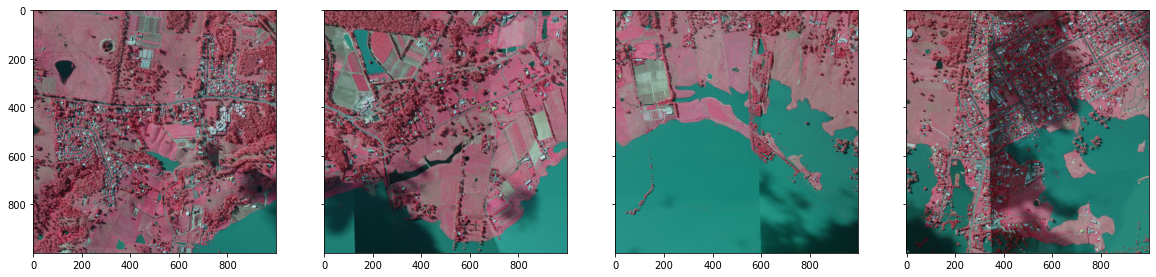

In [3]:
path = "images/"

image00 = "Hawkesbury-Nepean_Floods_Central_Sector_2021_03_15cm_NRG_51.jp2" 
image01 = "Hawkesbury-Nepean_Floods_Central_Sector_2021_03_15cm_NRG_52.jp2"
image02 = "Hawkesbury-Nepean_Floods_Central_Sector_2021_03_15cm_NRG_53.jp2"
image03 = "Hawkesbury-Nepean_Floods_Central_Sector_2021_03_15cm_NRG_54.jp2"

img_list = list()
_img00 = cv2.resize(io.imread(f"{path}/{image00}"), (0,0), fx=0.1, fy=0.1)
img_list.append(_img00)
_img01 = cv2.resize(io.imread(f"{path}/{image01}"), (0,0), fx=0.1, fy=0.1)
img_list.append(_img01)
_img02 = cv2.resize(io.imread(f"{path}/{image02}"), (0,0), fx=0.1, fy=0.1)
img_list.append(_img02)
_img03 = cv2.resize(io.imread(f"{path}/{image03}"), (0,0), fx=0.1, fy=0.1)
img_list.append(_img03)
pltImages(img_list)

Convert images to HSV colour space

In [4]:
hsv_img_list = list()

for img in img_list:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_img_list.append(hsv_img)